In [1]:
# List datasets mounted under /kaggle/input
!ls /kaggle/input/


fracture-multi-region-x-ray-data


In [2]:
import os, zipfile

# Path where Kaggle mounted your dataset
dataset_path = "/kaggle/input/fracture-multi-region-x-ray-data/fracture-multi-region-x-ray-data.zip"
extract_to   = "/kaggle/working/data"

# If it's a zip file, extract it
if os.path.exists(dataset_path):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(" Dataset extracted to:", extract_to)
    base_path = os.path.join(extract_to, "Bone_Fracture_Binary_Classification", "Bone_Fracture_Binary_Classification")
else:
    # If already unzipped, just point to it directly
    base_path = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification"

print("Base path set to:", base_path)


Base path set to: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification


In [7]:

# Walk through all folders and subfolders
for root, dirs, files in os.walk(base_path):
    print("📁", root)
    for d in dirs:
        print("   └──", d)


📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification
   └── val
   └── test
   └── train
📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val
   └── not fractured
   └── fractured
📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured
📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured
📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test
   └── not fractured
   └── fractured
📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured
📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Bin

In [3]:
# Define dataset splits
train_dir = os.path.join(base_path, "train")
val_dir   = os.path.join(base_path, "val")
test_dir  = os.path.join(base_path, "test")

# Quick check
print("Train:", train_dir)
print("Val:", val_dir)
print("Test:", test_dir)


Train: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train
Val: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val
Test: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test


In [4]:
def count_images(path):
    fractured = len(os.listdir(os.path.join(path, "fractured")))
    not_fractured = len(os.listdir(os.path.join(path, "not fractured")))
    return fractured, not_fractured

train_f, train_nf = count_images(train_dir)
val_f, val_nf     = count_images(val_dir)
test_f, test_nf   = count_images(test_dir)

print("TRAIN:", train_f, "fractured |", train_nf, "not fractured")
print("VAL  :", val_f, "fractured |", val_nf, "not fractured")
print("TEST :", test_f, "fractured |", test_nf, "not fractured")


TRAIN: 4606 fractured | 4640 not fractured
VAL  : 337 fractured | 492 not fractured
TEST : 238 fractured | 268 not fractured


In [6]:
from PIL import Image

def remove_corrupt_images(directory):
    removed = 0
    for root, _, files in os.walk(directory):
        for fname in files:
            file_path = os.path.join(root, fname)
            try:
                img = Image.open(file_path)
                img.verify()
            except Exception:
                os.remove(file_path)
                removed += 1
    return removed

total_removed = 0
for path in [train_dir, val_dir, test_dir]:
    total_removed += remove_corrupt_images(path)

print(" Removed corrupted images:", total_removed)


 Removed corrupted images: 0


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_gen  = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='binary')
val_data   = val_gen.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='binary')
test_data  = test_gen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=False)


print("Class indices:", train_data.class_indices)


Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Class indices: {'fractured': 0, 'not fractured': 1}


In [11]:
#  Build MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Fine-tune last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 1,690,497 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [12]:
# Callbacks (save inside /kaggle/working/)
checkpoint = ModelCheckpoint(
    filepath="/kaggle/working/mobilenetv2_model_best.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

In [14]:
#  Train
history_mob = mobilenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/25
191/289 ━━━━━━━━━━━━━━━━━━━━ 1:01 629ms/step - accuracy: 0.8486 - loss: 0.3514

E0000 00:00:1758205392.347916     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758205392.545554     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.8747 - loss: 0.2976

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.77443, saving model to /kaggle/working/mobilenetv2_model_best.h5
289/289 ━━━━━━━━━━━━━━━━━━━━ 208s 721ms/step - accuracy: 0.8749 - loss: 0.2971 - val_accuracy: 0.7744 - val_loss: 0.7174
Epoch 2/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9850 - loss: 0.0467
Epoch 2: val_accuracy improved from 0.77443 to 0.88299, saving model to /kaggle/working/mobilenetv2_model_best.h5
289/289 ━━━━━━━━━━━━━━━━━━━━ 132s 457ms/step - accuracy: 0.9851 - loss: 0.0467 - val_accuracy: 0.8830 - val_loss: 0.3437
Epoch 3/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9917 - loss: 0.0239
Epoch 3: val_accuracy improved from 0.88299 to 0.93727, saving model to /kaggle/working/mobilenetv2_model_best.h5
289/289 ━━━━━━━━━━━━━━━━━━━━ 132s 455ms/step - accuracy: 0.9917 - loss: 0.0239 - val_accuracy: 0.9373 - val_loss: 0.1881
Epoch 4/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9928 - loss: 0.0186
Epoch 4: val_accuracy improved fr

In [18]:
from tensorflow.keras.models import load_model

# Load best checkpoint model
mobilenet_model = load_model("/kaggle/working/mobilenetv2_model_best.h5")
print(" Loaded MobileNetV2 best model")

 Loaded MobileNetV2 best model


In [19]:
train_loss, train_acc = mobilenet_model.evaluate(train_data, verbose=0)
val_loss, val_acc     = mobilenet_model.evaluate(val_data, verbose=0)
test_loss, test_acc   = mobilenet_model.evaluate(test_data, verbose=0)

print(" Model: MobileNetV2")
print(f" Training Accuracy:   {train_acc*100:.2f}%, Loss: {train_loss:.4f}")
print(f" Validation Accuracy: {val_acc*100:.2f}%, Loss: {val_loss:.4f}")
print(f" Test Accuracy:       {test_acc*100:.2f}%, Loss: {test_loss:.4f}")


 Model: MobileNetV2
 Training Accuracy:   99.92%, Loss: 0.0023
 Validation Accuracy: 99.64%, Loss: 0.0203
 Test Accuracy:       99.21%, Loss: 0.0386


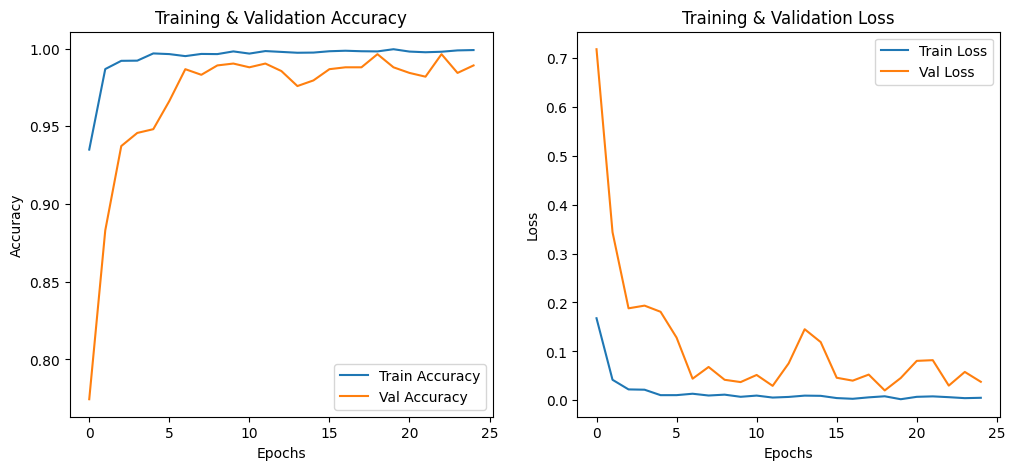

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_mob.history['accuracy'], label='Train Accuracy')
plt.plot(history_mob.history['val_accuracy'], label='Val Accuracy')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_mob.history['loss'], label='Train Loss')
plt.plot(history_mob.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [21]:
#  Classification Report (balanced)
from sklearn.metrics import classification_report

# Predicted probabilities and classes
y_pred_prob = mobilenet_model.predict(test_data).ravel()
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
y_true = test_data.classes

print("Classification Report:")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=["Fractured", "Not Fractured"]
))


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step
Classification Report:
               precision    recall  f1-score   support

    Fractured       1.00      0.98      0.99       238
Not Fractured       0.99      1.00      0.99       268

     accuracy                           0.99       506
    macro avg       0.99      0.99      0.99       506
 weighted avg       0.99      0.99      0.99       506



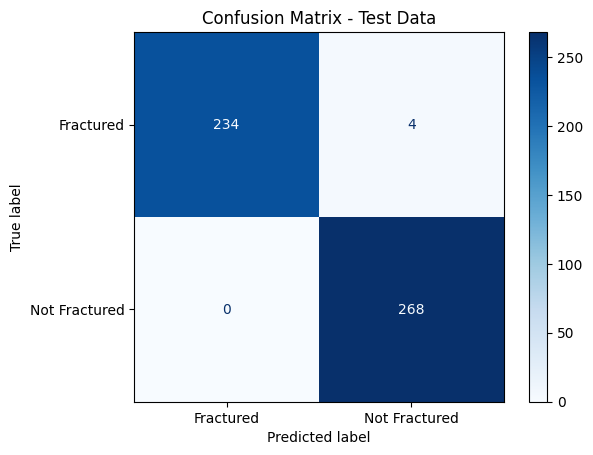

In [22]:
#  Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fractured", "Not Fractured"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test Data")
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step


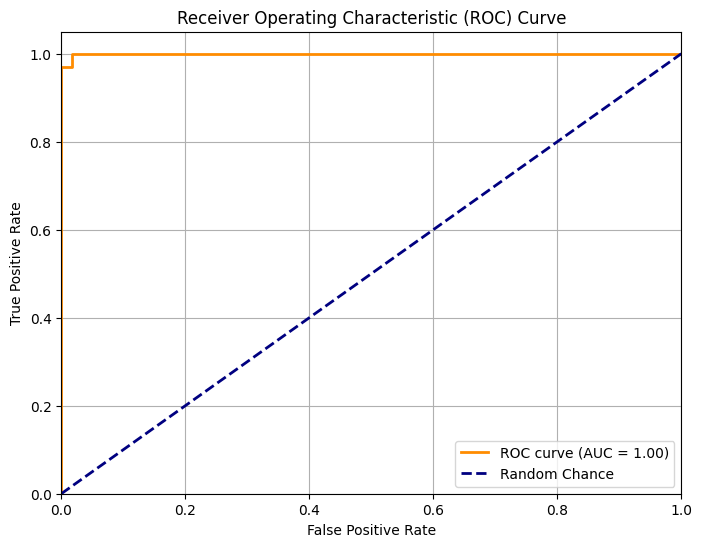

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# True labels
y_test = test_data.classes

# Predicted probabilities for the positive class
y_pred_prob = mobilenet_model.predict(test_data).ravel()

# ROC curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [35]:
import ipywidgets as widgets
from IPython.display import display

# File upload widget
upload = widgets.FileUpload(
    accept='image/*',
    multiple=False
)
display(upload)


FileUpload(value=(), accept='image/*', description='Upload')

In [39]:
import os

def save_uploaded_file(upload_widget, save_dir="/kaggle/working/"):
    if not upload_widget.value:
        raise ValueError("No file uploaded! Please upload an image first.")
    
    # On Kaggle, upload.value is a tuple
    uploaded_file = upload_widget.value[0]  # first (and only) file
    filename = uploaded_file['name']
    content = uploaded_file['content']
    
    file_path = os.path.join(save_dir, filename)
    with open(file_path, "wb") as f:
        f.write(content)
    
    print("Uploaded file saved to:", file_path)
    return file_path

# Save file and get path
img_path = save_uploaded_file(upload)


Uploaded file saved to: /kaggle/working/0085.png


In [40]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load & preprocess
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Predict
raw_output = mobilenet_model.predict(x)
prob = float(raw_output[0][0])
pred_class = int(round(prob))  # 0 = Fractured, 1 = Not Fractured
class_labels = ["Fractured", "Not Fractured"]

print(f"Raw output: {raw_output}")
print(f"Predicted probability (closer to 0 = Fractured): {prob:.4f}")
print(f"Prediction: {class_labels[pred_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Raw output: [[4.6432507e-17]]
Predicted probability (closer to 0 = Fractured): 0.0000
Prediction: Fractured


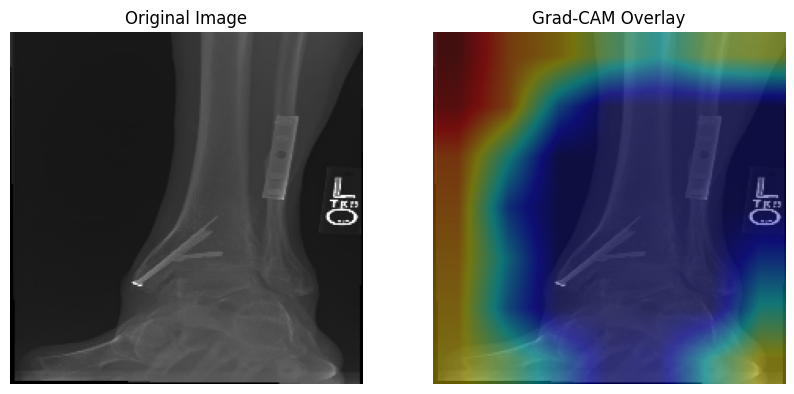

In [41]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np

def get_gradcam(model, img_array, last_conv_layer_name="block_16_project"):
    """
    Generates Grad-CAM heatmap for the predicted class.
    """
    # Create a model mapping input to last conv layer + output
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # Gradients of top predicted class w.r.t conv layer
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    
    # Weight conv outputs by pooled gradients
    for i in range(pooled_grads.shape[0]):
        conv_outputs[:,:,i] *= pooled_grads[i]
    
    # Compute heatmap
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap

# Generate Grad-CAM heatmap
heatmap = get_gradcam(mobilenet_model, x, last_conv_layer_name="block_16_project")

# Overlay heatmap on original image
img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (224,224))
heatmap_resized = cv2.resize(heatmap, (224,224))
heatmap_colored = cv2.applyColorMap(np.uint8(255*heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)

# Display
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Grad-CAM Overlay")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
